In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.linear_model
π = np.pi

# Confidence interval for the mean of a sample

Dataset: $x=(x_1,\dots,x_n)$

Model: $X_i\sim N(\mu,\sigma^2)$, where $\mu$ and $\sigma$ are unknown.

Find a 95% interval for $\hat{\mu}$. Recall that the mle is $\hat{\mu}=\bar{x}$.

In [2]:
x = [4.3, 5.1, 6.1, 6.8, 7.4, 8.8, 9.9]

95% confint [5.54,8.28]


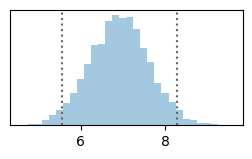

In [3]:
# Parametric resampling
# Fit the model, then sample n datapoints from the fitted model

def t(x): return np.mean(x) # readout statistic
μhat = np.mean(x)
σhat = np.sqrt(np.mean((x-μhat)**2))
def rx_star(): return np.random.normal(loc=μhat, scale=σhat, size=len(x))
t_ = [t(rx_star()) for _ in range(10000)]
lo,hi = np.quantile(t_, [.025, .975])
print(f"95% confint [{lo:.3},{hi:.3}]")

fig,ax = plt.subplots(figsize=(3,1.5))
ax.hist(t_, bins=30, alpha=.4)
ax.axvline(lo, linestyle='dotted', color='0.4')
ax.axvline(hi, linestyle='dotted', color='0.4')
ax.set_yticks([])
plt.show()

In [4]:
# Non-parametric resampling
# To generate a synthetic dataset, simply sample n datapoints from the empirical distribution

def t(x): return np.mean(x) # readout statistic
def rx_star(): return np.random.choice(x, size=len(x))
t_ = [t(rx_star()) for _ in range(10000)]
lo,hi = np.quantile(t_, [.025, .975])
lo,hi

(5.628571428571428, 8.342857142857142)

# Confidence interval for comparing two groups

Dataset: $x=(x_1,\dots,x_m)$, $y=(y_1,\dots,y_n)$

Model: $X_i\sim N(\mu,\sigma^2)$, $Y_i\sim N(\mu+\delta,\sigma^2)$.

Find a 95% interval for the estimated difference between the two groups $\hat{\delta}$. 
Recall that this is $\hat{\delta}=\bar{y}-\bar{x}$; the mles $\hat{\mu}$ and $\hat{\sigma}$ are given in the code.

95% confint [-0.422,3.72]


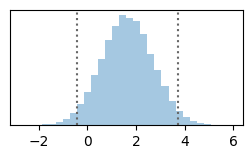

In [5]:
x = [4.3, 5.1, 6.1, 6.8, 7.4, 8.8, 9.9]
y = [8.3, 8.5, 8.9]
m,n = len(x), len(y)

# 1. Define a readout statistic
def t(x,y): return np.mean(y) - np.mean(x)

# 2. To generate a synthetic dataset ...
# Note that when we compute MLEs we compute them by maximizing log Pr(data;params)
# over ALL the data and ALL the parameters. When we resample, we resample the FULL data,
# consisting of both x and y.
μhat,δhat = np.mean(x), np.mean(y)-np.mean(x)
σhat = np.sqrt((np.sum((x-μhat)**2) + np.sum((y-μhat-δhat)**2))/(m+n))
def rxy():
    return (np.random.normal(loc=μhat, scale=σhat, size=m), 
            np.random.normal(loc=μhat+δhat, scale=σhat, size=n))

# 3. Sample the readout statistic, and reports its spread
t_ = [t(*rxy()) for _ in range(50000)]
lo,hi = np.quantile(t_, [.025, .975])
print(f"95% confint [{lo:.3},{hi:.3}]")

fig,ax = plt.subplots(figsize=(3,1.5))
ax.hist(t_, bins=30, alpha=.4)
ax.axvline(lo, linestyle='dotted', color='0.4')
ax.axvline(hi, linestyle='dotted', color='0.4')
ax.set_yticks([])
plt.show()

# Climate model: likelihood comparison and confidence intervals

In [6]:
url = 'https://www.cl.cam.ac.uk/teaching/current/DataSci/data/climate.csv'
climate = pandas.read_csv(url)
climate['t'] = climate.yyyy + (climate.mm - 1) / 12
climate['temp'] = (climate.tmin + climate.tmax) / 2

df = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1990)]
print(len(df))
df.iloc[-3:]

429


,yyyy,mm,tmax,tmin,af,rain,sun,status,station,lat,lng,height,t,temp
7438,2025,7,24.9,14.3,0,44.8,---,Provisional,Cambridge,52.245,0.102,26,2025.500000,19.60
7439,2025,8,24.5,13.0,0,16.0,---,Provisional,Cambridge,52.245,0.102,26,2025.583333,18.75
7440,2025,9,20.2,10.0,0,38.6,---,Provisional,Cambridge,52.245,0.102,26,2025.666667,15.10


In [7]:
# Periodic model
model0 = sklearn.linear_model.LinearRegression()
def X0(t): return np.column_stack([np.sin(2*π*t), np.cos(2*π*t)])
model0.fit(X0(df.t), df.temp)
None

In [8]:
# Model with linear trend
# I've defined the last feature so that the parameter is measured in deg C / century.
model1 = sklearn.linear_model.LinearRegression()
def X1(t): return np.column_stack([np.sin(2*π*t), np.cos(2*π*t), (t-2000)/100])
model1.fit(X1(df.t), df.temp)
model1.coef_[-1]

3.0196128899042187

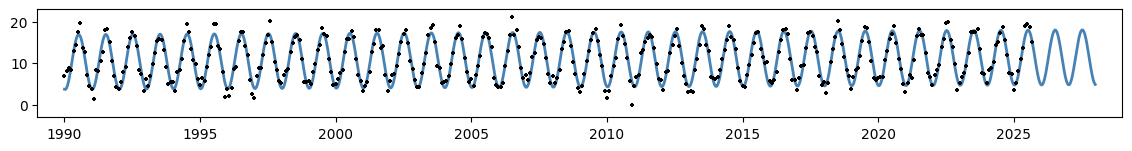

In [9]:
# Plot of the linear-trend model
newt = np.linspace(1990,2028,1000)
newtemp = model1.predict(X1(newt))

fig,ax = plt.subplots(figsize=(14,1.4))
ax.set_xlim([1989,2029])
ax.set_ylim([-3,23])
ax.plot(newt, newtemp, color='steelblue', linewidth=2, zorder=0)
ax.scatter(df.t, df.temp, marker='+', color='black', s=5)
plt.savefig('/home/djw/winhome/Downloads/climate1.svg', transparent=False, bbox_inches='tight', pad_inches=0)
plt.show()

In [10]:
# Compare log likelihoods
def loglik(ε):
    σ = np.sqrt(np.mean(ε**2))
    return - 1/2*np.sqrt(2*π*σ**2) - 1/(2*σ**2)*np.mean(ε**2)

loglik(df.temp - model0.predict(X0(df.t))), loglik(df.temp - model1.predict(X1(df.t)))

(-2.3091686410524948, -2.2665181146343087)

In [11]:
# Confidence interval for the trend term.
# My 95% confidence interval doesn't include 0. So I'm confident the trend term should be here.

# 1. Define the readout statistic, γhat
m = sklearn.linear_model.LinearRegression()
x = X1(df.t)
def trend(temp): return m.fit(x,temp).coef_[-1]

# 2. Fit the model, and generate resampled data based on the fitted model
pred1 = model1.predict(X1(df.t))
ε = df.temp - model1.predict(X1(df.t))
σ = np.sqrt(np.mean(ε**2))
def tempstar(): return np.random.normal(loc=pred1, scale=σ)

# 3. Find the spread of the readout statistic
γ_ = [trend(tempstar()) for _ in range(20000)]
lo,hi = np.quantile(γ_,[.025,.975])
lo,hi

(1.7474882365404674, 4.30945417955402)

In [12]:
# Model with quadratic trend.
# My 95% confidence interval for the quadratic coefficient does include 0.
# So I'm not confident that we need a quadratic.

def X2(t): return np.column_stack([np.sin(2*π*t), np.cos(2*π*t), t-2000, ((t-2000)/20)**2])
m = sklearn.linear_model.LinearRegression()
x = X2(df.t)
def t(temp): return m.fit(x,temp).coef_[-1]

model2 = sklearn.linear_model.LinearRegression()
model2.fit(X2(df.t), df.temp)
pred2 = model2.predict(X2(df.t))
ε = df.temp - model2.predict(X2(df.t))
σ = np.sqrt(np.mean(ε**2))
def tempstar(): return np.random.normal(loc=pred2, scale=σ)

# 3. Find the spread of the readout statistic
γ_ = [t(tempstar()) for _ in range(20000)]
lo,hi = np.quantile(γ_,[.025,.975])
lo,hi

(-0.13475559665101422, 0.9913726891136272)

# Fisher's tea-tasting hypothesis test

Null hypothesis: the taster can't taste the difference between milk-first and tea-first cups of tea.

Experiment: There were 8 cups of tea made, 4 with milk first and 4 with tea first. They were shuffled, out of sight of the taster. The taster guessed the labels.

Dataset: a list e.g. $[0,1,1,0,0,1,0,1]$ denoting the taster's labels, 0 for milk-first, 1 for tea-first. The truth is $[0,0,0,0,1,1,1,1]$.

Test statistic: number of labels that are correct.

Observed data: the taster got all 8 labels correct.

In [14]:
# This code uses simulation to find the distribution of t(X*).
# We could also do an exact calculation -- see Wikipedia, https://en.wikipedia.org/wiki/Lady_tasting_tea

true_labels = np.array([0,0,0,0,1,1,1,1])
def t(x): return np.sum(x==true_labels)
def rx_star(): return np.random.permutation(true_labels)
t_ = np.array([t(rx_star()) for _ in range(50000)])

vals,counts = np.unique(t_, return_counts=True)
t_hist = pandas.Series(counts/len(t_), index=vals)
print(t_hist)

# A one-sided p-value, for the observed data
p = np.mean(t_ >= 8)
p

0    0.01428
2    0.23050
4    0.51632
6    0.22492
8    0.01398
dtype: float64


0.01398

# Hypothesis test for comparing two groups

Dataset: $x=(x_1,\dots,x_m)$, $y=(y_1,\dots,y_n)$

Research question: are the two groups different?

Test statistic: let's use $\bar{y}-\bar{x}$. If they come from the same distribution, this should be close to 0. If they come from different distributions (or, more precisely, if they come from distributions with different means), this might go more +ve or it might go more -ve, depending on the difference in means. So we want a two-sided test.

In [15]:
x = [4.3, 5.1, 6.1, 6.8, 7.4, 8.8, 9.9]
y = [8.3, 8.5, 8.9]

def t(x,y): return np.mean(y) - np.mean(x)

p=0.16


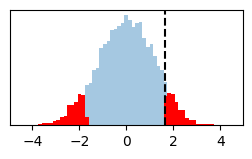

In [16]:
# Non-parametric hypothesis test.

# H0:
# that the two groups come from the same distribution.
# If H0 is true, then the best possible fit for their common distribution
# is the empirical distribution of [x1,...,xm,y1,...,yn]

# Resampling. As usual, we want to return a synthetic dataset of the same shape as the observed dataset
def rxy():
    return (np.random.choice(np.concatenate([x,y]), size=len(x)),
            np.random.choice(np.concatenate([x,y]), size=len(y)))

# Sample the test statistic, compare to observed value, find the p-value
# In this case, "extreme" means "large +ve or large -ve", so we want a two-sided p-value
t_ = np.array([t(*rxy()) for _ in range(10000)])
p = 2 * min(np.mean(t_>=t(x,y)), np.mean(t_<=t(x,y)))
print(f"p={p:.3}")

fig,ax = plt.subplots(figsize=(3,1.5))
bins = np.linspace(-4.5, 4.5, 60)
ax.hist(t_, bins=bins, alpha=.4)
ax.hist(t_[(t_ >= t(x,y)) | (t_ <= np.quantile(t_,p/2))], bins=bins, color='red')
ax.axvline(t(x,y), linestyle='dashed', color='black')
ax.set_yticks([])
plt.show()

p=0.156


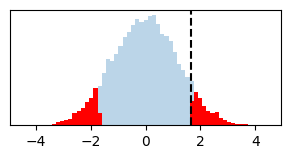

In [17]:
# Parametric hypothesis test.

# H0:
# that the two groups are both drawn from N(μ,σ^2)
# where parameters μ and σ are unknown

# Resampling. 
# Fit H0, then sample from it.
# As usual, we want to return a synthetic dataset of the same shape as the observed dataset
μhat = np.mean(np.concatenate([x,y]))
σhat = np.sqrt(np.mean((np.concatenate([x,y])-μhat)**2))
def rxy(): 
    return (np.random.normal(loc=μhat, scale=σhat, size=len(x)),
            np.random.normal(loc=μhat, scale=σhat, size=len(y)))

# The p-value calculation is the same as for the non-parametric case.
t_ = np.array([t(*rxy()) for _ in range(10000)])
p = 2 * min(np.mean(t_ >= t(x,y)), np.mean(t_ <= t(x,y)))
print(f"p={p:.3}")

fig,ax = plt.subplots(figsize=(3.5,1.5))
bins = np.linspace(-4.5, 4.5, 60)
ax.hist(t_, bins=bins, alpha=.3)
ax.hist(t_[t_>=t(x,y)], bins=bins, color='red')
ax.hist(t_[t_<=np.quantile(t_,p/2)], bins=bins, color='red')
ax.axvline(x=t(x,y), linestyle='dashed', color='black')
ax.set_yticks([])
plt.show()

# Hypothesis test for comparing several groups

Dataset: three lists of values, $x$, $y$, and $z$

General model: $X_i\sim N(\mu_x,\sigma^2)$, $Y_i\sim N(\mu_y,\sigma^2)$, $Z_i\sim N(\mu_z,\sigma^2)$.

$H_0$: $\mu_x=\mu_y=\mu_z$.

Test statistic: $t=(\hat{\mu}_x-\hat{\mu})^2+(\hat{\mu}_y-\hat{\mu})^2+(\hat{\mu}_z-\hat{\mu})^2$,
where $\hat{\mu}$ is the MLE under the $H_0$ model which says all the means are equal and have common value $\mu$.
If $H_0$ is false, we'd expect $t$ to be large (bigger +ve). So we want a one-sided test: reject $H_0$ if $t$ is large.

p=0.596


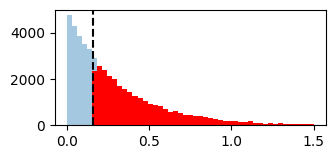

In [18]:
x = [7.2, 7.3, 7.8, 8.2, 8.8, 9.5]
y = [8.3, 8.5, 9.2]
z = [7.4, 8.5, 9.0]

# Define the test statistic
def t(x,y,z):
    m = np.mean(np.concatenate([x,y,z]))
    a,b,c = [np.mean(v) for v in [x,y,z]]
    return (a-m)**2 + (b-m)**2 + (c-m)**2

# 2. To generate a synthetic dataset, assuming H0 ...
xyz = np.concatenate([x,y,z])
μhat = np.mean(xyz)
σhat = np.sqrt(np.mean((xyz-μhat)**2))
def rxyz():
    return (np.random.normal(size=len(x), loc=μhat, scale=σhat),
            np.random.normal(size=len(y), loc=μhat, scale=σhat),
            np.random.normal(size=len(z), loc=μhat, scale=σhat))

# 3. Sample the test statistic, find the p-value
t_ = np.array([t(*rxyz()) for _ in range(50000)])
p = np.mean(t_ >= t(x,y,z))
print(f"p={p:.3}")

fig,ax = plt.subplots(figsize=(3.5,1.5))
bins = np.linspace(0, 1.5, 50)
ax.hist(t_, bins=bins, alpha=.4)
ax.hist(t_[t_>=t(x,y,z)], bins=bins, color='red')
ax.axvline(t(x,y,z), linestyle='dashed', color='black')
plt.show()